In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=4
!nvidia-smi

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=4
Thu Jan 26 15:04:29 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.129.06   Driver Version: 470.129.06   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:01:00.0 Off |                    0 |
| N/A   50C    P0    96W / 275W |  41181MiB / 81251MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100-SXM... 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import torchvision.utils as vutils
import json
import PIL
import logging
import sys
import getpass

sys.path.insert(1, '/home/' + getpass.getuser() + '/Projects/DiffusionSimple/util')

In [4]:
from loaders import generateDatasets, inOut, saveJSON, loadJSON#, MyData
from NNets import SimpleCNN, SimpleCNNConvT, SimpleCNN_L, SimpleCNN_S, UNet, LeakyUNet
from tools import accuracy, tools, per_image_error, predVsTarget
from plotter import myPlots, plotSamp, plotSampRelative

# class DiffSur(SimpleCNN100):
# 	pass

# class DiffSur(SimpleCNN):
# 	pass

# class DiffSur(JuliaCNN100):
# 	pass
def select_nn(arg, d=None, num_samples=1):
    if arg == "SimpleCNN":
        class DiffSur(SimpleCNN):
            pass 
    elif arg == "UNet":
        class DiffSur(UNet):
            pass
    elif arg == "SimpleCNNConvT":
        class DiffSur(SimpleCNNConvT):
            pass
    elif arg == "SimpleCNN_L":
        class DiffSur(SimpleCNN_L):
            pass
    elif arg == "SimpleCNN_S":
        class DiffSur(SimpleCNN_S):
            pass
    elif arg == "LeakyUNet":
        class DiffSur(LeakyUNet):
            pass
    return DiffSur()

In [5]:
###Start Here
PATH = '/home/' + getpass.getuser() +'/Projects/DiffusionSimple/Results/' #"/raid/javier/Datasets/DiffusionSimple/"
DATASETNAME = "Data"

dir = 'model0'
BATCH_SIZE=50
NUM_WORKERS=8
ngpu = 1
lr = 0.0001
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# dict = inOut().newDict(PATH, dir)
os.listdir(os.path.join(PATH, "Dict", dir))[0]
dict = inOut().loadDict(os.path.join(PATH, "Dict", dir, os.listdir(os.path.join(PATH, "Dict", dir))[0]))
dict["lr"]=lr
dict

{'Class': [],
 'Gen': [],
 'Disc': [],
 'Enc': [],
 'Diff': ['/home/javier/Projects/DiffusionSimple/Results/Models/model0/Diff-backup.pt'],
 'Diff-Best': ['/home/javier/Projects/DiffusionSimple/Results/Models/model0/Diff-Best.pt'],
 'Path': ['/home/javier/Projects/DiffusionSimple/Results/Dict/model0/Dict-2023-01-25-16-35.json'],
 'Loss': [0.2272816698998213,
  0.22058735424652695,
  0.20925093218684196,
  0.1960364674217999,
  0.1885646430309862,
  0.18382032900117337,
  0.1804937671404332,
  0.1775547825265676,
  0.1746985729318112,
  0.1717801284044981,
  0.16909264558926224,
  0.1662669274955988,
  0.1637939112726599,
  0.1612667061854154,
  0.1585987677332014,
  0.1564535098616034,
  0.15421010348945857,
  0.1522531073074788,
  0.1503967136144638,
  0.14861260806210339,
  0.14728172039613127,
  0.1458301292732358,
  0.14412703849375247,
  0.14304095916450024,
  0.14172816993668674,
  0.14053088622167706,
  0.13951945598237217,
  0.13836151915602385,
  0.13743170006200672,
  0.13643

In [6]:
from matplotlib.pyplot import imshow, show 
trainloader, testloader = generateDatasets(PATH, datasetName=DATASETNAME, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, s=256, transformation="linear").getDataLoaders()


/home/javier/miniconda3/lib/python3.9/site-packages/torchvision/transforms/transforms.py:287: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


In [7]:
r = next(iter(trainloader))

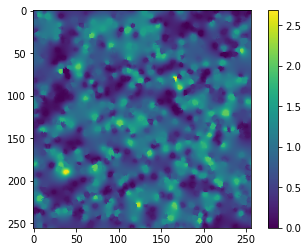

In [8]:
plt.imshow(r[1][0,0,:,:].numpy())
plt.colorbar()

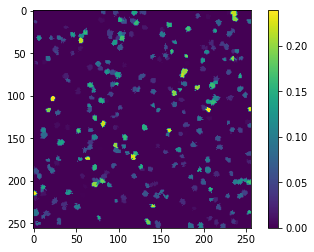

In [9]:
plt.imshow(r[0][0,0,:,:].numpy())
plt.colorbar()

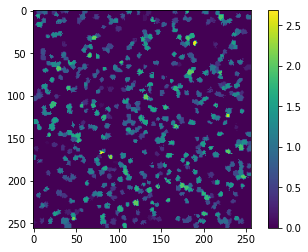

In [10]:
plt.imshow(r[0][0,1,:,:].numpy())
plt.colorbar()

In [15]:
diffSolv = select_nn(dict['NN']) # DiffSur().to(device)
diffSolv = diffSolv.to(device)
# ep,err, theModel = inOut().load_model(diffSolv, "Diff", dict)
lastEpoch, _, diffSolv = inOut().load_model(diffSolv, "Diff", dict)

In [16]:
yhat = diffSolv(r[0].to(device))

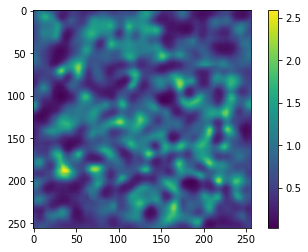

In [17]:
plt.imshow(yhat[0,0,:,:].detach().cpu().numpy())
plt.colorbar()

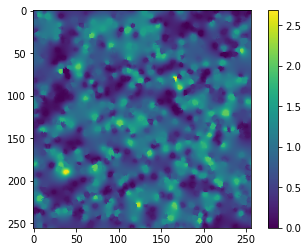

In [18]:
plt.imshow(r[1][0,0,:,:].numpy())
plt.colorbar()

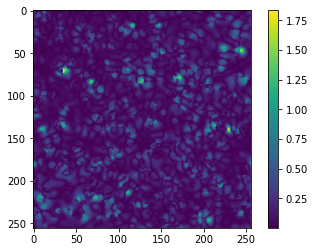

In [19]:
plt.imshow(np.abs(r[1][0,0,:,:].numpy() - yhat[0,0,:,:].detach().cpu().numpy()))
plt.colorbar()

In [ ]:
# Try changing upsample for ConvTranspose
# Try reducing the bottleneck H and W
# Try increasing the bottleneck H and W
# |x> -> AE -> cat(|x>, |z>) -> CNN -> |y>


# Slowly increase the stack of the input into the output

In [27]:
nn.ConvTranspose2d(32, 1, 2, 2, 0)(torch.rand(2,32,11,11)).shape

torch.Size([2, 1, 22, 22])